# Expectation-maximisation (EM)

Key ideas:
* assumes data is generated from $k$ unseen distributions
* uses MLE to estimate the parameters of those distributions

Advantages:
* fast
* can learn more complex cluster structures than k-means

Disadvantages:
* does not work well with small clusters
* sensitive to the number of dimensions - curse of dimensionality (same as for k-NN).

Online resources:
* Step-by-step description of EM (Victor Lavrenko): https://youtu.be/-mYQ-nbykCo

## Motivation

k-means is a robust algorithm, however it has trouble finding "alongated" or overlapping clusters.

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
# Anisotropically distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
anis = np.dot(X, transformation)
# Compare these datasets
d1, d2 = X, anis

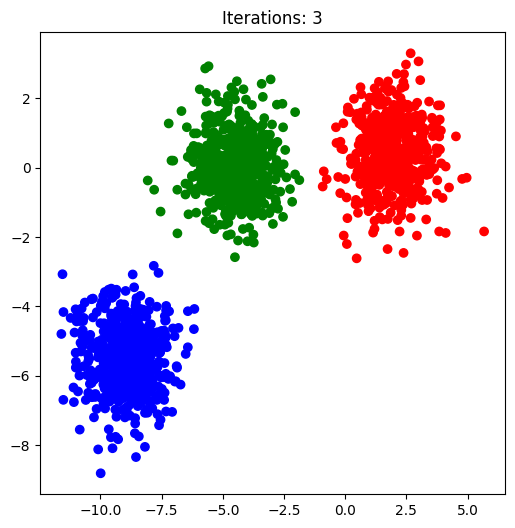

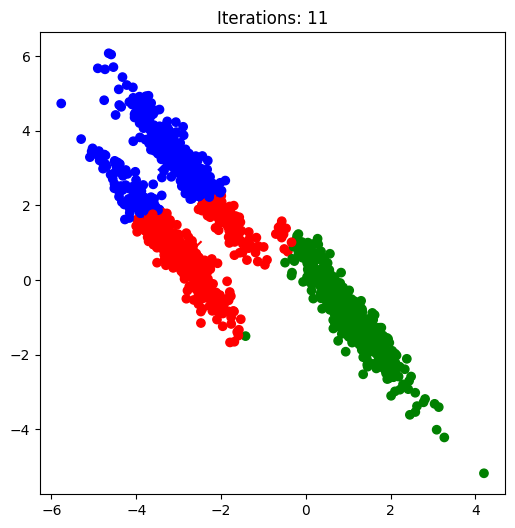

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
for d in [d1, d2]:
    km = KMeans(n_clusters=3, n_init=10)
    clusters = km.fit_predict(d)
    centroids = km.cluster_centers_
    # Plot clusters
    fig, ax = plt.subplots(figsize=(6, 6))
    c = ListedColormap(['red', 'green', 'blue'])
    plt.scatter(centroids[:,0], centroids[:,1], s=100, marker='x', 
                c=range(len(centroids)), cmap=c)
    plt.scatter(d[:,0], d[:,1], c=clusters, cmap=c)
    plt.title(f'Iterations: {km.n_iter_}')
    plt.show()

EM for Gaussian mixture models refines this idea, by assuming that the clusters are generated from $k$ normal distributions. It then repeatedly applies MLE to find the parameters of those distributions in a two-step process very similar to k-means.

It is then capabable of learning both types of shapes:

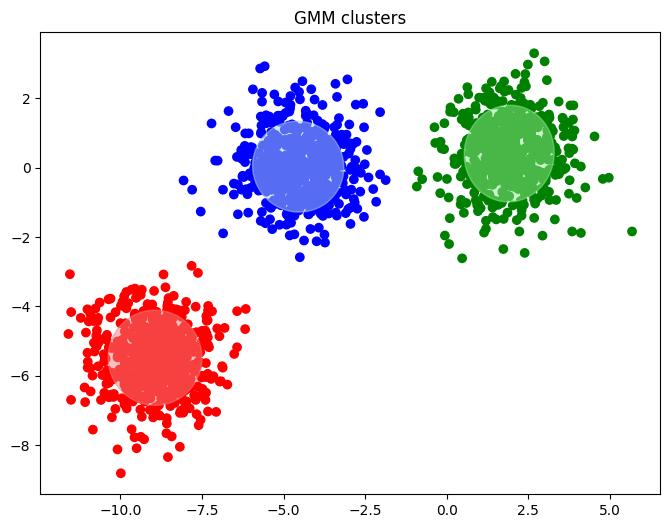

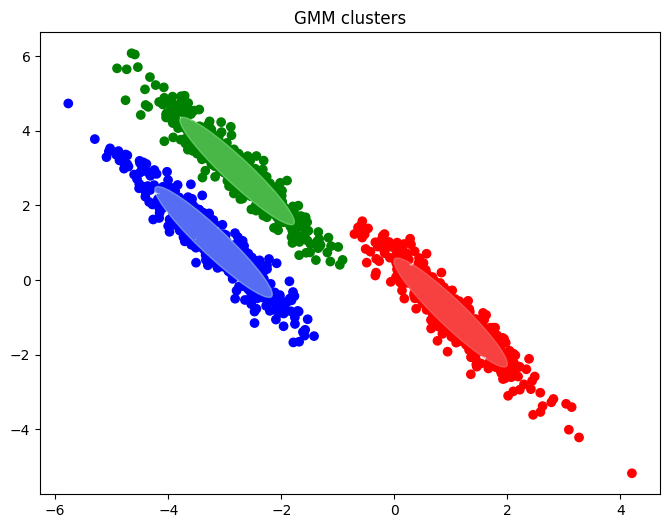

In [3]:
# fit a Gaussian Mixture Model with two components
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from tools.plots import add_ellipses

for d in [d1, d2]:

    clf = GaussianMixture(n_components=3, covariance_type='full')
    clf.fit(d)


    fig, ax = plt.subplots(figsize=(8, 6))
    clusters = clf.predict(d)

    c1 = ListedColormap(['red', 'green', 'blue'])
    c2 = ['lightcoral', 'lightgreen', 'lightblue']
    ax.scatter(d[:, 0], d[:, 1], c=clusters, cmap=c1)

    add_ellipses(clf, ax, c2)

    plt.title('GMM clusters')
    plt.axis('tight')
    plt.show()


## Step-by-step example for estimating the means

Let's take a simple dataset with six points:

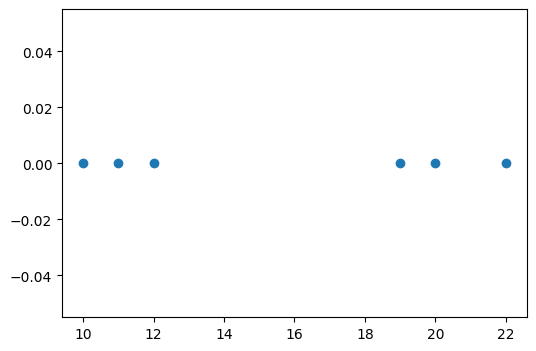

In [4]:
import pandas as pd
d = pd.DataFrame({
    'X': [10, 11, 12, 19, 20, 22]
})
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d['X'], np.zeros_like(d))
plt.show()

We will assume the data points are generated by 2 distributions of variance 1.5 and unknown means $\mu_1$ and $\mu_2$. Note that the variance is typically estimated at the same time as the mean, but we're fixing it here for clarity.

Since the distributions themselves have the same probabilities $\pi_1=\pi_2=\frac{1}{2}$ of being selected, we can say that that pdf of any point is:

$$ pdf(x) = \frac{1}{2}N(x|\mu_0, 1.5) + \frac{1}{2}N(x|\mu_1, 1.5) $$

### Step 1 - Initial step

Pick at random a hypothesis $h^{(0)}=<\mu_1^{(0)}, \mu_2^{(0)}>$. Let's say that the two means picked are $\mu_0=10$ and $\mu_1=11$. We can now plot the two normal distributions:

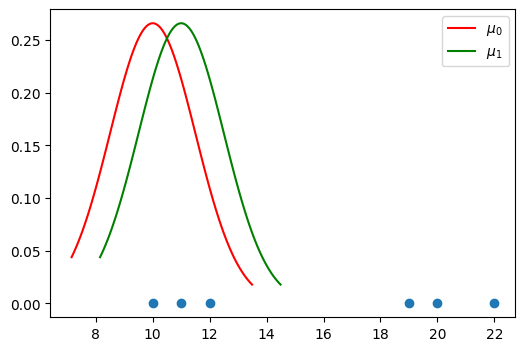

In [5]:
from matplotlib.colors import ListedColormap
from scipy.stats import norm

c = ListedColormap(['red', 'green'])

means = [10, 11]
variances = [1.5, 1.5]

def plot_pdfs(means, variances, ax, colours):
    """ Plot the pdfs for given means and variances """
    for i in range(0, 2):
        mean, var = means[i], variances[i]
        x = np.linspace(norm.ppf(0.01, mean, np.sqrt(var)), norm.ppf(0.99, mean, var), 100)
        pdf = norm.pdf(x, mean, var)
        ax.plot(x, pdf, color=colours(i), label=f"$\\mu_{i}$")
        ax.legend()

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d))
plot_pdfs(means, variances, ax, c)
plt.show()

### Step 2 - Expectation

Let $z_{ij} \in \{0, 1\}$ be a variable denoting if the point $x_i$ is generated by the distribution $j$. Of course, we don't know which point was generated from which distribution, therefore these are called "hidden variables" and they need to be estimated.

Assuming that the current hypothesis $h^{(0)}$ holds, for each hidden variable $z_{ij}$ calculate the expected value $E[z_{ij}|x_i]$ which therefore represents the probability that the point $x_i$ is generated by the distribution $j$ (as opposed to any other distribution). Expanding this formula gives (*see the lecture for how this was calculated*):

$$ E[z_{ij}|x_i] = P(z_{ij}=1 | x_i) = \frac{p(x=x_i|\mu = \mu_j)}{\sum_{n=1}^2p(x=x_i|\mu = \mu_n)} $$

where $p(x=x_i|\mu = \mu_j)$ is simply the _pdf_ function of the normal distribution of mean $\mu_j$. We can the apply the calculations:

In [6]:
p_1 = norm.pdf(d, means[0], np.sqrt(variances[0]))
p_2 = norm.pdf(d, means[1], np.sqrt(variances[1]))

E0 = p_1 / (p_1 + p_2) # E for j=0 (red distribution)
E1 = p_2 / (p_1 + p_2) # E for j=1 (green distribution)
print("E for j=0:\n", E0)
print("E for j=1:\n", E1)

E for j=0:
 [[5.82570206e-01]
 [4.17429794e-01]
 [2.68941421e-01]
 [3.44745130e-03]
 [1.77295459e-03]
 [4.67956726e-04]]
E for j=1:
 [[0.41742979]
 [0.58257021]
 [0.73105858]
 [0.99655255]
 [0.99822705]
 [0.99953204]]


And if we color each point according to the expected values, they become:

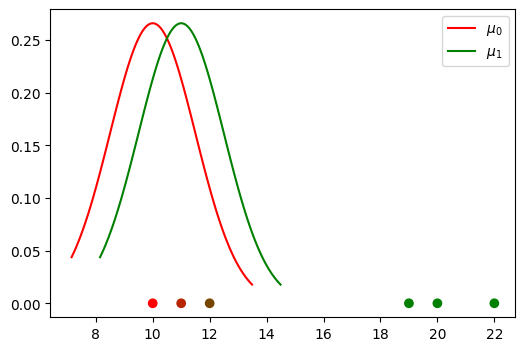

In [7]:
from matplotlib.colors import LinearSegmentedColormap

c_grad = LinearSegmentedColormap.from_list('mygrad', [c(0), c(1)])

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d), c=E1, cmap=c_grad)
plot_pdfs(means, variances, ax, c)
plt.show()

### Step 3 - Maximisation

Using the expected values of $z_{ij}$ we can go back and refine the two distributions, this time using MLE to find their means instead of choosing them at random. Formally, the algorithm will choose a new maximum likelihood hypothesis $h^{(1)}=<\mu_1^{(1)}, \mu_2^{(1)}>$.

Using the formulas for the Gaussian models in our case, we have (*see the lecture for how this was calculated*):

$$ \mu_j^{(1)} \leftarrow \frac{\sum_{i=1}^mE[z_{ij}]x_i}{\sum_{i=1}^{m}E[z_{ij}]} $$

In [8]:
x = d.to_numpy()
means[0] = (E0 * x).sum() / E0.sum()
means[1] = (E1 * x).sum() / E1.sum()
print("Updated means are: ", means)

Updated means are:  [np.float64(10.792139597966287), np.float64(16.981530285942945)]


If we plot the distributions corresponding to the new means, we have:

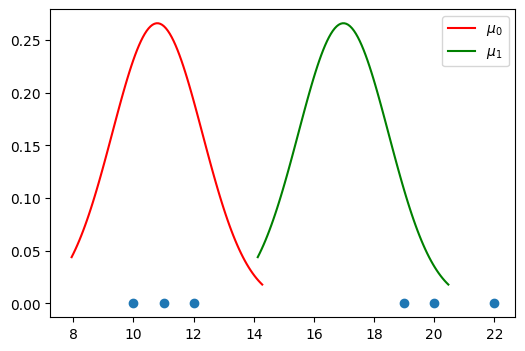

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d))
plot_pdfs(means, variances, ax, c)
plt.show()

### Convergence

The algorithm will keep repeating steps 2 and 3 until the means no longer change significantly.

Let's see the second iteration:

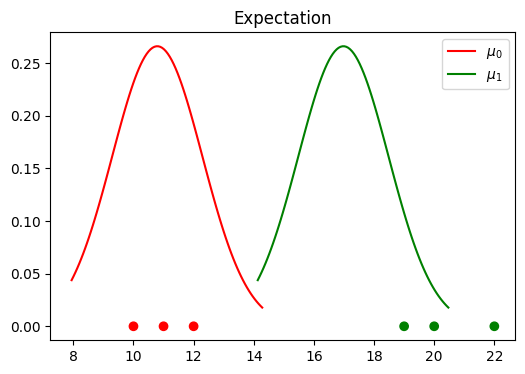

In [10]:
p_1 = norm.pdf(d, means[0], np.sqrt(variances[0]))
p_2 = norm.pdf(d, means[1], np.sqrt(variances[1]))

E0 = p_1 / (p_1 + p_2) # E for j=0
E1 = p_2 / (p_1 + p_2) # E for j=1

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d), c=E1, cmap=c_grad)
plot_pdfs(means, variances, ax, c)
plt.title('Expectation')
plt.show()

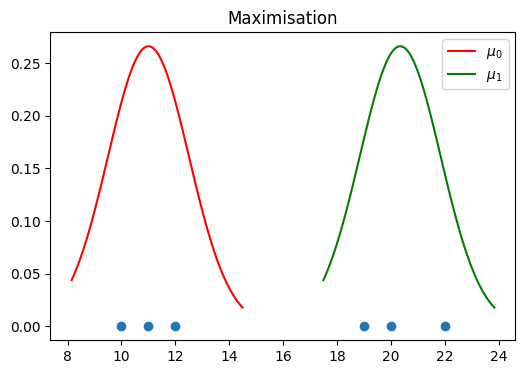

In [11]:
means[0] = (E0 * x).sum() / E0.sum()
means[1] = (E1 * x).sum() / E1.sum()

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d))
plot_pdfs(means, variances, ax, c)
plt.title("Maximisation")
plt.show()

And the third: 

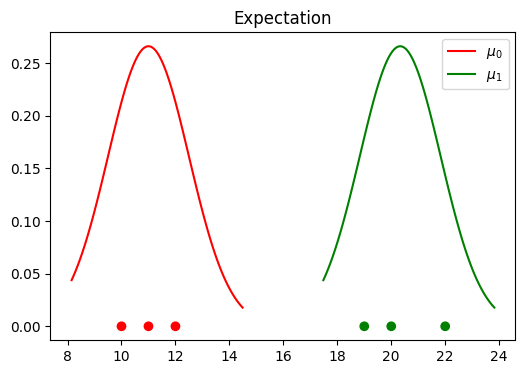

In [12]:
p_1 = norm.pdf(d, means[0], np.sqrt(variances[0]))
p_2 = norm.pdf(d, means[1], np.sqrt(variances[1]))

E0 = p_1 / (p_1 + p_2) # E for j=0
E1 = p_2 / (p_1 + p_2) # E for j=1

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d), c=E1, cmap=c_grad)
plot_pdfs(means, variances, ax, c)
plt.title('Expectation')
plt.show()

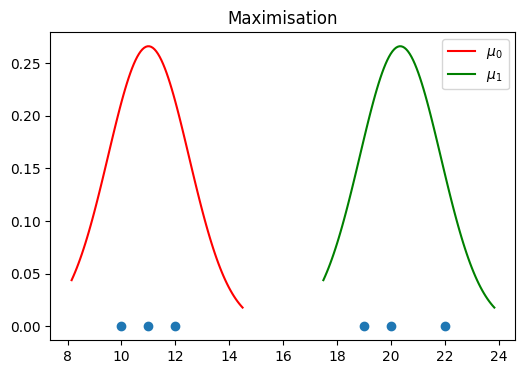

In [13]:
means[0] = (E0 * x).sum() / E0.sum()
means[1] = (E1 * x).sum() / E1.sum()

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(d, np.zeros_like(d))
plot_pdfs(means, variances, ax, c)
plt.title("Maximisation")
plt.show()

We can already see that the last maximisation step did not move the means by much, so the algorithm has converged.

## scikit-learn implementation

The entire algorithm is already available in Python in the `GaussianMixture` class. It can optimise both the mean and the variance of the Gaussian distributions. Here is how the iterations look like:

In [14]:
clf = GaussianMixture(n_components=2, covariance_type='full', max_iter=12, init_params='random', random_state=3, means_init=[[11], [12]])
clf.fit(d)
print(clf.predict_proba(d)[:,0])
print(clf.means_)
print(clf.weights_)
print(clf.covariances_)

[1.00000000e+00 1.00000000e+00 1.00000000e+00 3.85524922e-21
 6.54860073e-27 1.44406177e-39]
[[11.        ]
 [20.33333333]]
[0.5 0.5]
[[[0.66666767]]

 [[1.55555656]]]


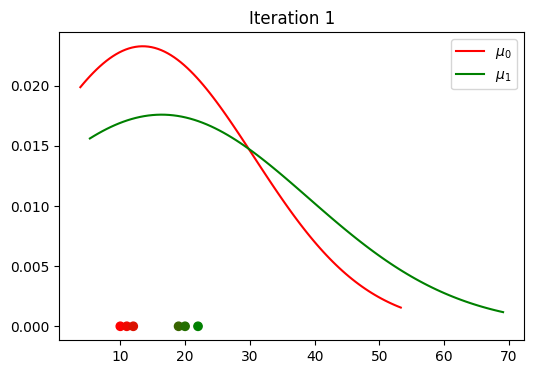

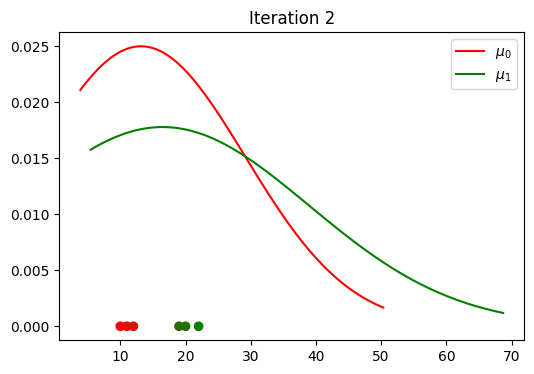

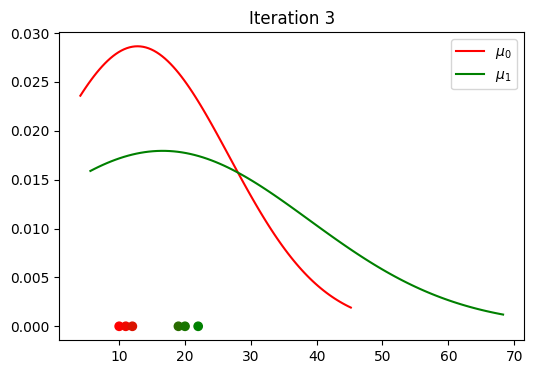

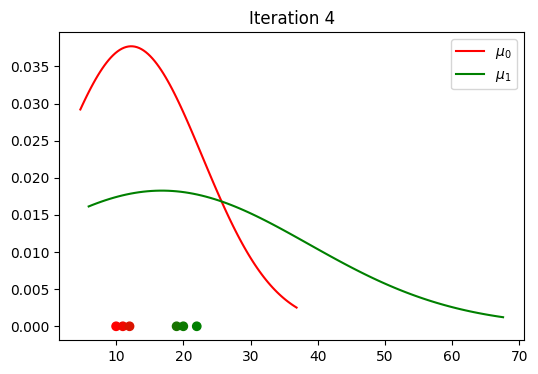

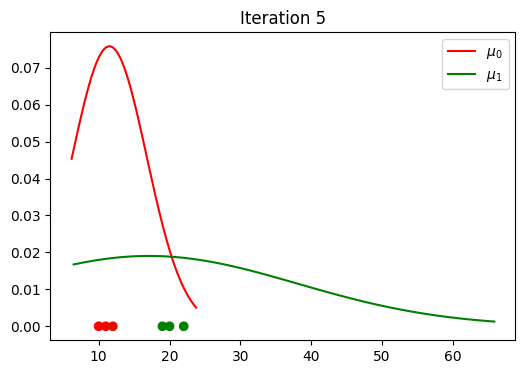

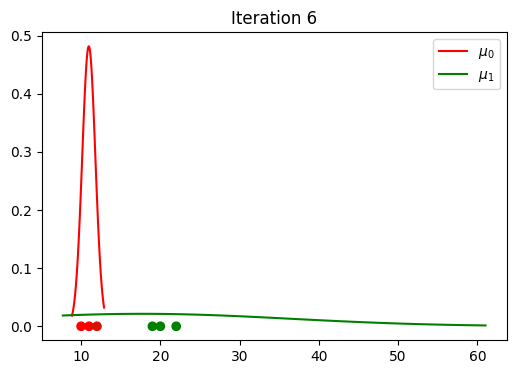

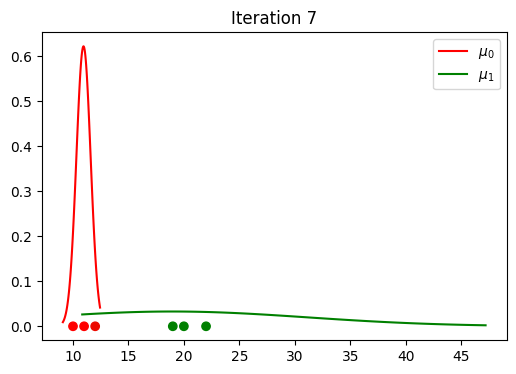

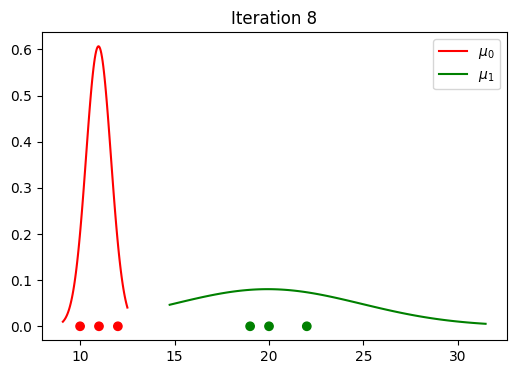

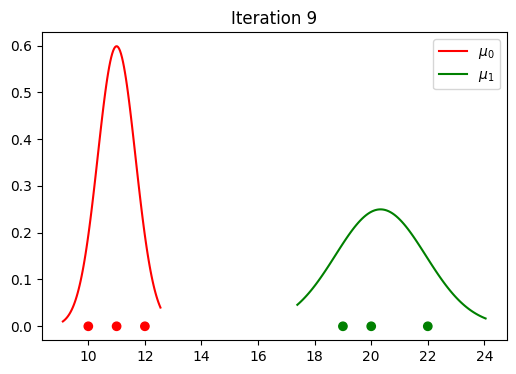

In [15]:
from sklearn.mixture import GaussianMixture
import warnings

def print_GM_steps():
    for step in range(1, 10):
        clf = GaussianMixture(n_components=2, covariance_type='full', \
                              max_iter=step, init_params='random', \
                              random_state=3, means_init=[[11], [12]])
        clusters = clf.fit(d)
        cl_proba = clf.predict_proba(d)[:,1]
        fig, ax = plt.subplots(figsize=(6, 4))
        plt.scatter(d, np.zeros_like(d), c=cl_proba, cmap=c_grad)
        means = clf.means_[:,0]
        variances = clf.covariances_[:,0][:,0]
        plot_pdfs(means, variances, ax, c)
        plt.title(f"Iteration {step}")
        plt.show()
        
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print_GM_steps()

## Bernoulli mixture models

_See problem 6 page 939 for full calculations._

* First coin yields Head with probability $p$.
* Second coin yields Head with probability $q$.
* The first coin is chosen with probability $\pi$.
* Observed results and starting values are in the code below.

In [16]:
from scipy.stats import bernoulli

def rv(p, rs):
    return bernoulli.rvs(p, size=10000, random_state=rs)

def create_X(p, q, pi):
    rvs_pi = rv(pi, 1)
    rvs_p = rv(p, 2)
    rvs_q = rv(q, 3)
    X = np.array([rvs_p[i] if rvs_pi[i]==1 else rvs_q[i] for i in range(len(rvs_p))])
    print(f"Generated X of length {len(X)} starting with: {X[0:10]}")
    print(f"Observed p={rvs_p.mean():.2}, q={rvs_q.mean():.2}, pi={rvs_pi.mean():.2}")
    print(f"Observed E[X]={X.mean():.2}")
    return X

p = 0.25
q = 0.25
pi = 0.5
#p, q, pi = (0.526504857055877, 0.013541926928177454, 0.48077172557172543)
X = create_X(p, q, pi)

Generated X of length 10000 starting with: [0 0 0 0 1 1 0 0 0 0]
Observed p=0.25, q=0.25, pi=0.5
Observed E[X]=0.25


### Step 1 - Initial step

Initialise with given arbitrary values $h^{(0)}=<p^{(0)}, q^{(0)}, \pi^{(0)}>$.

In [17]:
p = 1/10
q = 1/10
pi = 1/10
p, q, pi

(0.1, 0.1, 0.1)

### Step 2 - Expectation

Let $z_i \in \{0, 1\}$ be a "hidden" variable denoting if at throw $i$ was used the first coin. So for example, $z_2=1$ means that at the second throw the first coin was used.

$$\begin{aligned}
E[z_{i}|x_i] &=0 \cdot P(z_{i}=0|x_i)+1 \cdot P(z_{i}=1|x_i) \\
&= P(z_i=1|x_i) \\
&= \frac{p^{x_i} \cdot (1-p)^{1-x_i} \cdot \pi}{p^{x_i} \cdot (1-p)^{1-x_i} \cdot \pi + q^{x_i} \cdot (1-q)^{1-x_i} \cdot (1-\pi)}
\end{aligned}$$

where $p^{x_i} \cdot (1-p)^{1-x_i}$ is simply the pdf of the Bernoulli distribution for each point $x_i$.

In [18]:
#E=...

### Step 3 - Maximisation

The most likely $p$ is:

$$
p^{(t+1)}=\frac{\sum_{i=0}^{n}E[z_{i}|x_i]^{(t)} \cdot x_i}{\sum_{i=0}^{n}E[z_{i}|x_i]^{(t)}}
$$

The most likely $q$ is:

$$
q^{(t+1)}=\frac{\sum_{i=0}^{n}(1-E[z_{i}|x_i])^{(t)} \cdot x_i}{\sum_{i=0}^{n}(1-E[z_{i}|x_i])^{(t)}}
$$

The most likely $\pi$ is:

$$
\pi^{(t+1)} = \frac{1}{n}\sum_{i=0}^{n}E[z_{i}|x_i]^{(t)}
$$

In [19]:
#p = ...
#q = ...
#pi = ...
print(f"The most likely p={p:.2}, q={q:.2}, pi={pi:.2}")

The most likely p=0.1, q=0.1, pi=0.1


## Did you enjoy the lab?

You can answer anonymously at https://forms.gle/DLuUiKKS7Z6CYZa46

## The end

In [20]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/Y6ljFaKRTrI?start=7" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>